In [1]:
import glob

img_list = glob.glob('figs/mnistv2/*/200.jpg')
print(len(img_list))

dict_img_position = {
    'main':[0, 200],
    'ht':[200, 650],
    'loss':[650, 920],
    'overall_results':[950, 1150]}

36


In [2]:
import matplotlib.pyplot as plt

def filter_results(H_complex_inits=['all'], m_inc_procs=['all'], Ts=['all'], initialization_biases=['all'], noises=['all'], H_weight_preprocesses=['all'], noise=['all']):
    interested_imgs = []
    for H_complex_init in H_complex_inits:
        for m_inc_proc in m_inc_procs:
            for T in Ts:
                for initialization_bias in initialization_biases:
                    for H_weight_preprocess in H_weight_preprocesses:
                        for noise in noises:
                            attrs = [f'H_complex_init({H_complex_init})', f'm_inc_proc({m_inc_proc})', f'T({T})', f'initialization_bias({initialization_bias})',f'noise({noise})', f'H_weight_preprocess({H_weight_preprocess})']
                            #print(attrs)
                            for img_dir in img_list:
                                flag=True
                                for attr in attrs:
                                    #print('check : ',attr.split('('))
                                    if attr.split('(')[1][:-1]=='all':
                                        flag=True
                                        continue
                                    else:
                                        if attr not in img_dir:
                                            flag= False
                                            break
                                if flag==True:interested_imgs.append(img_dir)
                                #else:print(img_dir)
    print(f'{len(interested_imgs)} images are found !!!')
    return interested_imgs

def show_results(key, dict_img_position, interested_imgs):
    start, end = dict_img_position[key]

    for img_dir in sorted(interested_imgs):
        plt.figure(figsize = (15,5))
        plt.imshow(plt.imread(img_dir)[start:end,:])
        plt.title(img_dir.split('/')[2])
        plt.show()


In [5]:
Ts=['5'] # 5, 2
H_complex_inits = ['all']
H_weight_preprocesses=  ['all'] #, 'fft', 'ifft', 'abs'
m_inc_procs =  ['all']
noise= ['True'] # True, False
initialization_biases = ['10'] # 10, 0

interested_imgs = filter_results(H_complex_inits, m_inc_procs, Ts, initialization_biases, noise, H_weight_preprocesses)

print(f'available keys : {list(dict_img_position.keys())}')

3 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']


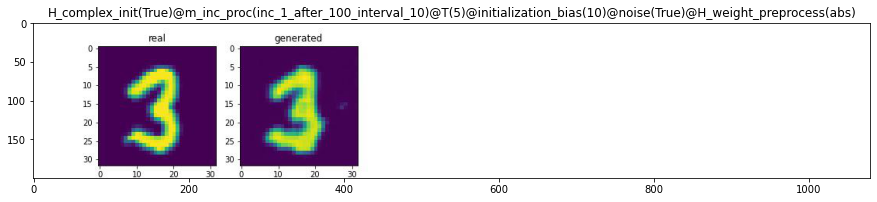

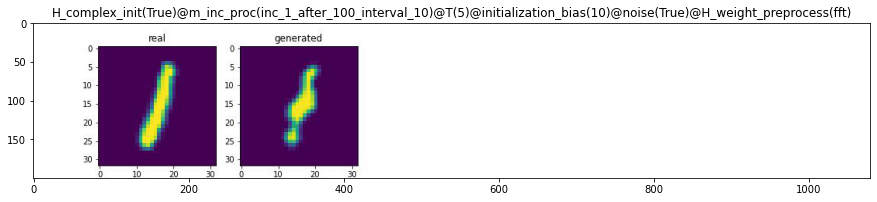

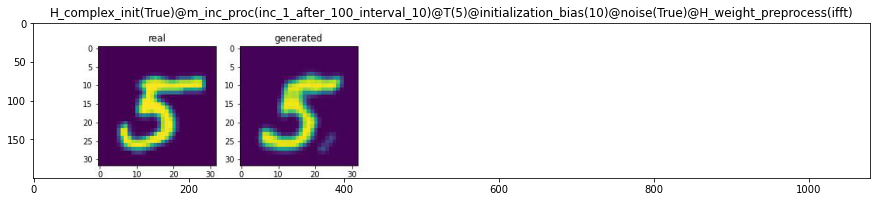

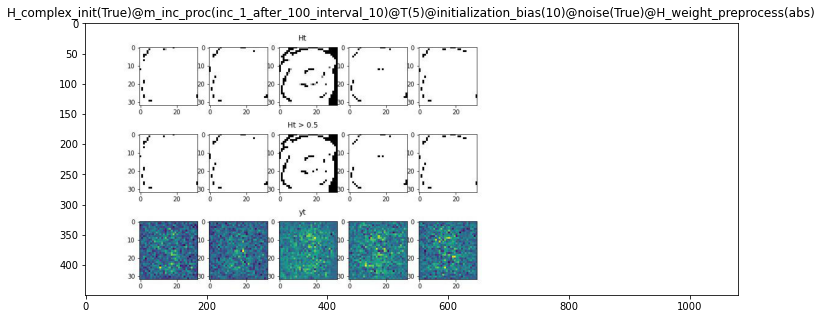

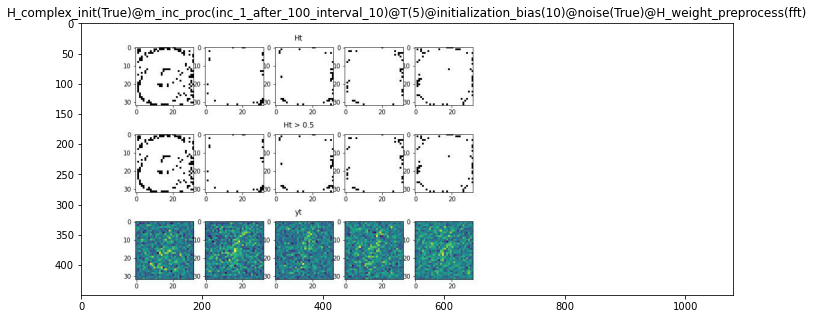

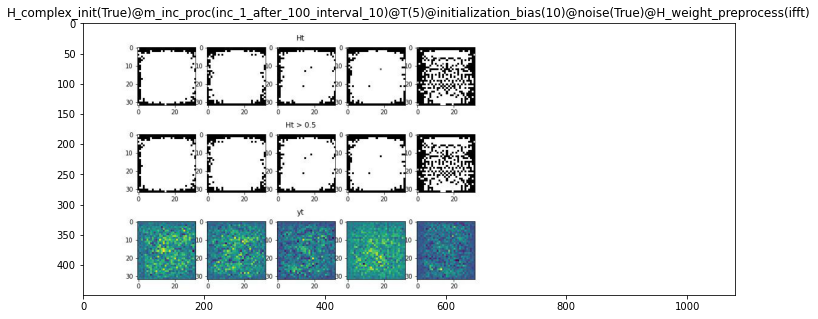

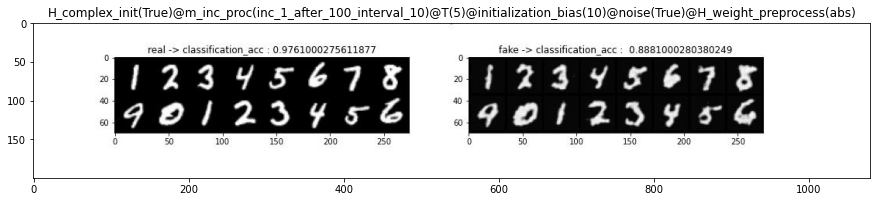

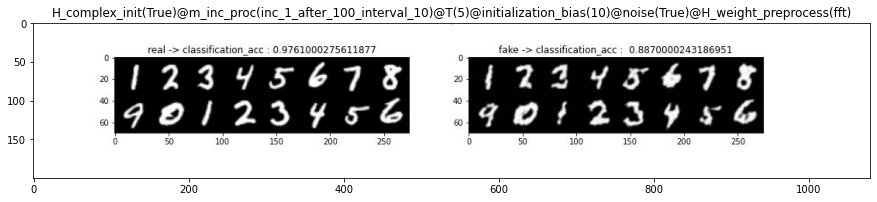

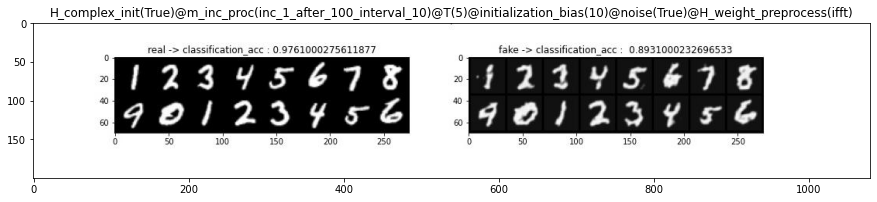

In [6]:
show_results('main', dict_img_position, interested_imgs)
show_results('ht', dict_img_position, interested_imgs)
show_results('overall_results', dict_img_position, interested_imgs)